## Overview
Author: Chenyu Shen (Rainy)
Last Updated: August, 16, 2020

This is a Jupyter notebook for graph representation of accounting reports, following GAAP standards. Transform accounting tables into graphs. This is a preliminary graph conversion, additional complexity could be added by breaking given accounts into more accounts, and many more analysis can be done once we have the graph framework set up, using graph algorithms and graph feature selections.

In [2]:
# Set up standard python analysis framework
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Set up graph framework
import networkx as nx
import matplotlib.pyplot as plt

## Import Data 

In [4]:
df = pd.read_csv("data_output/df_na_annual_13-19.csv")

In [5]:
len(df) # check data length

42985

## Data Preprocessing 

In [6]:
# sort by company and then by fiscal year
df = df.sort_values(by = ['cik','fyear'])

In [7]:
# drop not useful columns
df.drop(columns = ['ROA','ROE','cusip','gvkey'],inplace = True)

In [9]:
def selectCompany(company_name, begining_year, ending_year):
    ## TODO: handling company name not find
    ## TODO: handling accounts value not exist or = 0
    
    # select company
    company = df[df.conm.str.contains(company_name.upper())]
    # slice fiscal year for analysis
    company = company[(company.fyear == begining_year) | (company.fyear == ending_year)]
    company_two_years = company
    # calculate changes of selected accounts (current year - previous year)
    deltas = company.select_dtypes(include=['float64']).diff()
    delta_dct = {'Cash' : 'delta_cash',
                'NetNCAssets' : 'delta_net_nc_assets',
                'Contributed Capital' : 'delta_contrib_e'}
    deltas = deltas.rename(columns = delta_dct)
    # append delta results to original dataframe
    deltas = pd.concat([company,deltas[['delta_net_nc_assets','delta_cash','delta_contrib_e']]], axis = 1)
    # final result of the company with delta changes in current year
    company = deltas[(deltas['fyear'] == ending_year)]
    
    return company_two_years, company


In [10]:
# Example: walmart
company_name = 'walmart'
beg_year = 2013
end_year = 2014

company_two_years, company = selectCompany(company_name,
                                           beg_year,
                                           end_year)


In [11]:
company_two_years # current year & base year's data

,cik,conm,fyear,naicsh,Net Income(Loss),Cash,Assets - Total,Liabilities - Total,Stockholders' Equity - Total,Retained Earnings Unadjusted,Contributed Capital,Dividends - Total,NCAssets,NetNCAssets
5736,104169,WALMART INC,2013.0,452990.0,16022.0,7281.0,204751.0,121921.0,76255.0,76566.0,311.0,6139.0,197470.0,75549.0
5737,104169,WALMART INC,2014.0,452990.0,16363.0,9135.0,203706.0,117769.0,81394.0,85777.0,4383.0,6185.0,194571.0,76802.0


In [13]:
company # current year (end_year)

,cik,conm,fyear,naicsh,Net Income(Loss),Cash,Assets - Total,Liabilities - Total,Stockholders' Equity - Total,Retained Earnings Unadjusted,Contributed Capital,Dividends - Total,NCAssets,NetNCAssets,delta_net_nc_assets,delta_cash,delta_contrib_e
5737,104169,WALMART INC,2014.0,452990.0,16363.0,9135.0,203706.0,117769.0,81394.0,85777.0,4383.0,6185.0,194571.0,76802.0,1253.0,1854.0,4072.0


## Graph Representation

### Convert accounting tables into graph
Convert accounts and values into nodes and edges, and generate graph using NetworkX. The graph generation follows the GAAP rule.

In [11]:
def simpleGraphParam(company_name, beg_year, end_year):
    # select company's data
    company_two_years, company = selectCompany(company_name,
                                           beg_year,
                                           end_year)
    
    nodes = ['delta_cash',
        'delta_net_nc_assets',
        'delta_contrib_e',
        'Dividends - Total',
        'Net Income(Loss)']
    
    # values of each node
    # formula: 
    # delta_cash + delta_net_nc_assets - delta_contrib_e - Net Income + Div = 0
    nodes_value = {}
    for n in nodes:
        nodes_value[n] = float(company[n])
        if n == 'delta_contrib_e' or n == 'Net Income(Loss)':
            nodes_value[n] = -float(company[n])

    # create label for visualization purpuse
    nodes_label = {k:k+'\n'+str(v) for k,v in nodes_value.items()}
    
    # formula: 
    # delta_cash + delta_net_nc_assets - delta_contrib_e - Net Income + Div = 0
    edges = [('delta_cash','delta_contrib_e',
              {'weight': float(company['delta_contrib_e'])}),
            ('delta_cash', 'Dividends - Total',
            {'weight': float(company['Dividends - Total'])}),
            ('Net Income(Loss)', 'delta_net_nc_assets',
            {'weight' : float(company['Net Income(Loss)'])}),
            ('delta_net_nc_assets', 'delta_cash',
            {'weight' : float(company['Dividends - Total']) + 
                            float(company['delta_contrib_e']) +
                            float(company['delta_cash'])})]
    
    return nodes, nodes_label, edges


In [41]:
def genGraph(nodes, edges):
    # instantiate a new directed graph instance
    G = nx.DiGraph()
    G.clear()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

In [13]:
nodes, nodes_label, edges = simpleGraphParam('walmart', 2013, 2014)

In [14]:
G = genGraph(nodes,edges)

### Visualization 

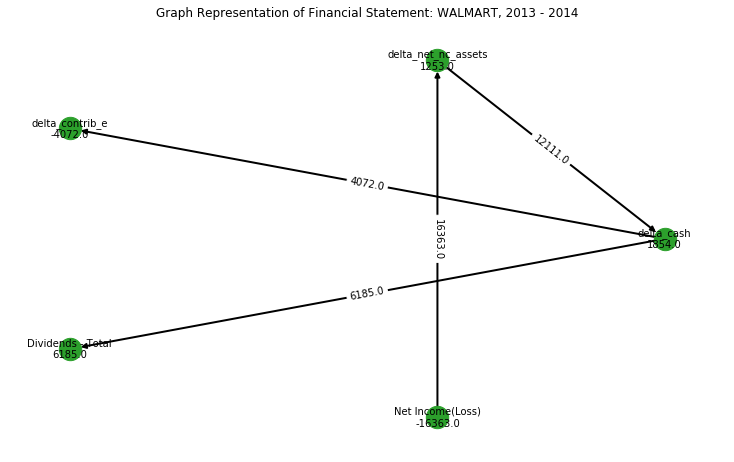

In [15]:
# Graph visualization

# graph nodes arrangement
plt.figure(figsize = (10,6))
pos = nx.circular_layout(G) 
# pos = nx.spring_layout(G)
# draw graph
nx.draw(G, pos,node_size = 500, 
        width = 2,
        arrow_style = 'fancy',
        node_color = 'tab:green',
        arrow_size = 60,
        font_size = 10,
        labels = nodes_label
       )
# draw edges with weight
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.draw()
plt.title("Graph Representation of Financial Statement: {}, {} - {}"
         .format(company_name.upper(), beg_year, end_year))
plt.show()


### Bringing in Income Statement 
Add one more layer of complexity from previous graph by brining in the income statements. Specifically, break the Net Income accounts into Revenue, and Expenses accounts as reflected in the income statemsnts.

In [55]:
# Get Walmart's performance from fiscal year 2013 - 2019, with selected income statement accounts.
df = pd.read_csv('data_output/df_na_annual_13-19_walmart.csv')

In [56]:
# Data processing to get data ready for analysis

# slice fiscal year for analysis
company = df[(df.fyear == 2013) | (df.fyear == 2014)]

# calculate changes of selected accounts (current year - previous year)
deltas = company.select_dtypes(include=['float64']).diff()

# restructure the dataframe with deltas
delta_dct = {'Cash' : 'delta_cash',
            'NetNCAssets' : 'delta_net_nc_assets',
            'Contributed Capital' : 'delta_contrib_e'}
deltas = deltas.rename(columns = delta_dct)
# append delta results to original dataframe
deltas = pd.concat([company,deltas[['delta_net_nc_assets','delta_cash','delta_contrib_e']]], axis = 1)
    
# final result ready for graph conversion
company = deltas[(deltas['fyear'] == 2014)]

# calculate expense
company['Expenses'] = company['Net Income(Loss)'] + company['Revenue - Total'] - company['Interest and Related Expense - Total'] - company['Income Taxes - Total']



In [57]:
company.columns, len(company)

(Index(['cik', 'conm', 'fyear', 'naicsh', 'Revenue - Total',
        'Income Taxes - Total', 'Operating Expenses Total',
        'Interest and Related Expense - Total', 'Net Income(Loss)', 'Cash',
        'Assets - Total', 'Liabilities - Total', 'Stockholders' Equity - Total',
        'Retained Earnings Unadjusted', 'Contributed Capital',
        'Dividends - Total', 'NCAssets', 'NetNCAssets', 'ROA', 'ROE',
        'delta_net_nc_assets', 'delta_cash', 'delta_contrib_e', 'Expenses'],
       dtype='object'), 1)

In [58]:
nodes = ['delta_cash',
        'delta_net_nc_assets',
        'delta_contrib_e',
        'Dividends - Total',
        'Revenue - Total',
         'Expenses',
         'Interest and Related Expense - Total',
        'Income Taxes - Total'
        ]

In [59]:
nodes_value = {}
for n in nodes:
    nodes_value[n] = float(company[n])
    if n == 'delta_contrib_e' or n == 'Revenue - Total':
        nodes_value[n] = -float(company[n])
        
# create label for visualization purpuse
nodes_label = {k:k+'\n'+str(v) for k,v in nodes_value.items()}

nodes_label, nodes_value

({'delta_cash': 'delta_cash\n1854.0',
  'delta_net_nc_assets': 'delta_net_nc_assets\n1253.0',
  'delta_contrib_e': 'delta_contrib_e\n-4072.0',
  'Dividends - Total': 'Dividends - Total\n6185.0',
  'Revenue - Total': 'Revenue - Total\n-483521.0',
  'Expenses': 'Expenses\n489379.0',
  'Interest and Related Expense - Total': 'Interest and Related Expense - Total\n2520.0',
  'Income Taxes - Total': 'Income Taxes - Total\n7985.0'},
 {'delta_cash': 1854.0,
  'delta_net_nc_assets': 1253.0,
  'delta_contrib_e': -4072.0,
  'Dividends - Total': 6185.0,
  'Revenue - Total': -483521.0,
  'Expenses': 489379.0,
  'Interest and Related Expense - Total': 2520.0,
  'Income Taxes - Total': 7985.0})

In [61]:
edges = [('delta_cash','delta_contrib_e',
          {'weight': float(company['delta_contrib_e'])}),

        ('delta_cash', 'Dividends - Total',
        {'weight': float(company['Dividends - Total'])}),
        
        ('delta_net_nc_assets', 'delta_cash',
        {'weight' : float(company['Dividends - Total']) + 
                        float(company['delta_contrib_e']) +
                        float(company['delta_cash'])}),
         
        ('Revenue - Total', 'delta_net_nc_assets',
        {'weight' : float(company['Revenue - Total'])}),
         
        ('delta_net_nc_assets','Expenses',
        {'weight' : -float(company['Expenses'])}),
         
        ('delta_net_nc_assets', 'Interest and Related Expense - Total',
        {'weight' : -float(company['Interest and Related Expense - Total'])}),
         
        ('delta_net_nc_assets', 'Income Taxes - Total',
        {'weight' : -float(company['Income Taxes - Total'])}),
         
        ('delta_cash', 'delta_net_nc_assets'),
        ('delta_cash', 'delta_net_nc_assets'),
        ('delta_cash', 'delta_net_nc_assets')]


In [65]:
G = genGraph(nodes,edges) # generate a NetworkX graph with encoded nodes and edges

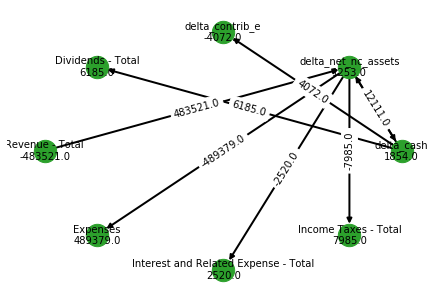

In [66]:
# graph nodes arrangement
pos = nx.circular_layout(G) 
# pos = nx.spring_layout(G)
# draw graph
nx.draw(G, pos,node_size = 500, 
        width = 2,
        arrow_style = 'fancy',
        node_color = 'tab:green',
        arrow_size = 60,
        font_size = 10,
        labels = nodes_label
       )
# draw edges with weight
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.draw()

### Validation
Some simple validation process of the graph generated, to make sure the data integrity and follows the GAAP rule. Iterate the graph (nodes and edges) to implement the validation.

In [109]:
# Validation

# checks the Income Statement
total_exp = 0
total_rev = 0

for u,v,weight in G.edges(data = True):
    
    if u == 'Revenue - Total':
        total_rev += float(weight['weight'])
    elif v == 'Income Taxes - Total' or v == 'Expenses' or v == 'Interest and Related Expense - Total':
        total_exp += float(weight['weight'])
        
# check if expense and revenue adds up to company's net income (absolute value) of that year
if abs(total_exp + total_rev) == abs(float(company['Net Income(Loss)'])):
    print(True)

True


In [100]:
total_rev, total_exp

(483521.0, -499884.0)

In [110]:
float(company['Net Income(Loss)'])

16363.0

## Reference:
1) NetworkX documentations and tutorial:
https://networkx.github.io/documentation/stable/tutorial.html  
2) GraphRepresentationOfFinStatements.pptx by Professor Pierre Liang